<a href="https://colab.research.google.com/github/vallekarla123-collab/Examen-Econometr-a-A01452031/blob/main/ExamenEcoA01452031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In relation to the book of Gujarati (basic econometrics), answer question 22.11 pp 799: Consider the data on log DPI (personal disposable income) introduced in Section 21.1
(see the book’s website for the current data). Suppose you want to fit a suitable ARIMA
model to these data. Outline the steps involved in carrying out this task

PASOS:

1.	Se grafica la serie de DPI para observar si existe alguna tendencia o estacionalidad.
2.	Evaluar estacionalidad y se concluye si es estacionara o no a través del valor p>0.05.
3.	Diferenciación, aplicar varias d para que la serie sea estacionaria.
4.	Identificar parámetros (p,q) para sugerir los posibles ordenes del modelo.
5.	Estimar el modelo con posibles combinaciones.
6.	Diagnosticar residuos, verificando que sean ruido blanco.
7.	Utilizar el modelo final para hacer el pronóstico y comparar con datos observados.
8.	Interpretar el significado e implicación económica.



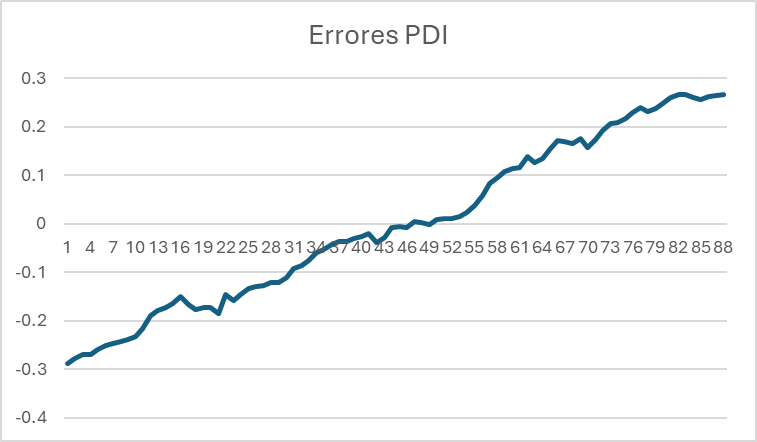

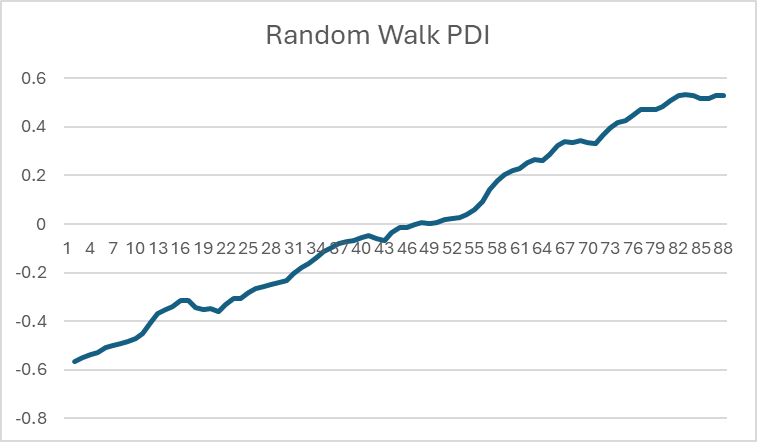

In [26]:
# =============================================
# 1. IMPORTS & CONFIGURACIÓN
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from google.colab import files

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [44]:
# =============================================
# 2. FUNCIÓN PARA CARGAR EL EXCEL (como en tu ejemplo)
# =============================================
def load_stock_data():
    print("Por favor, sube el archivo Excel: 'PDI.xlsx'")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    try:
        df = pd.read_excel(filename)
        print(f"\nArchivo cargado exitosamente: {filename}")
        print(f"Columnas detectadas: {list(df.columns)}")
        return df
    except Exception as e:
        raise ValueError(f"Error al leer el archivo Excel: {e}")

# Cargar datos
df = load_stock_data()

Por favor, sube el archivo Excel: 'PDI.xlsx'


Saving Información códio GROK.xlsx to Información códio GROK (5).xlsx

Archivo cargado exitosamente: Información códio GROK (5).xlsx
Columnas detectadas: ['YEAR', 'PDI']


In [35]:
# =============================================
# 3. PREPARAR LA SERIE DPI
# =============================================
# Asegurarse de que las columnas existan
if 'YEAR' not in df.columns or 'PDI' not in df.columns:
    raise ValueError("El archivo debe contener las columnas 'YEAR' y 'PDI'")

# Convertir YEAR a datetime (asumiendo años completos)
df['Date'] = pd.to_datetime(df['YEAR'], format='%Y')
df = df.set_index('Date')[['PDI']].sort_index()

# Eliminar valores faltantes
dpi = df['PDI'].dropna()

print(f"\nSerie DPI lista: {len(dpi)} observaciones")
print(f"Rango: {dpi.index[0].year} → {dpi.index[-1].year}")


Serie DPI lista: 88 observaciones
Rango: 1970 → 1991


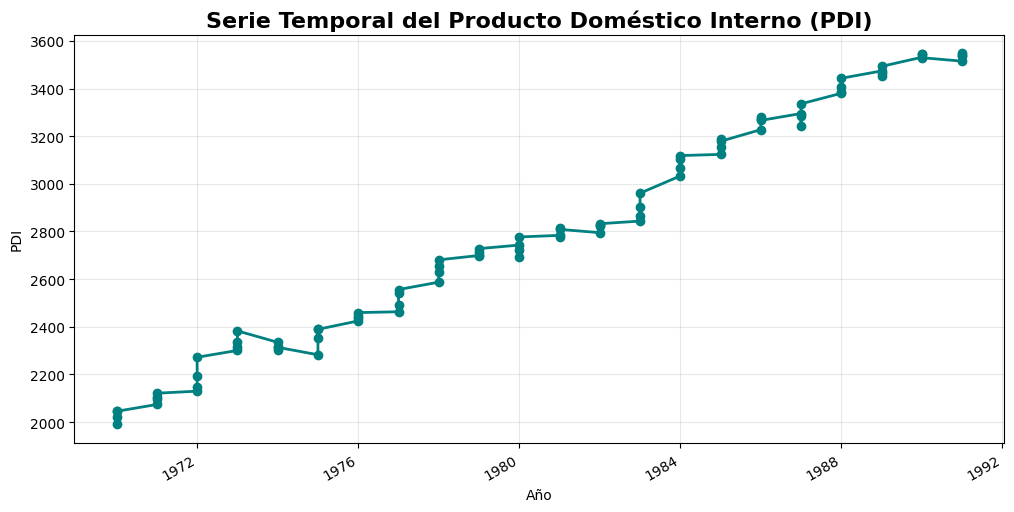

Observación visual:
→ ¿Hay tendencia clara? (creciente, decreciente, cíclica)
→ ¿Hay patrones repetitivos anuales? (estacionalidad)


In [36]:
# =============================================
# 4. GRAFICAR LA SERIE (TENDENCIA Y ESTACIONALIDAD)
# =============================================
plt.figure()
dpi.plot(marker='o', linewidth=2, color='teal')
plt.title('Serie Temporal del Producto Doméstico Interno (PDI)', fontsize=16, fontweight='bold')
plt.ylabel('PDI')
plt.xlabel('Año')
plt.grid(True, alpha=0.3)
plt.show()

print("Observación visual:")
print("→ ¿Hay tendencia clara? (creciente, decreciente, cíclica)")
print("→ ¿Hay patrones repetitivos anuales? (estacionalidad)")

In [37]:
# =============================================
# 5. EVALUAR ESTACIONALIDAD Y ESTACIONARIEDAD
# =============================================
def test_stationarity(series, name):
    print(f"\n{'='*20} PRUEBAS DE ESTACIONARIEDAD - {name} {'='*20}")

    # ADF Test
    adf = adfuller(series, autolag='AIC')
    print(f"ADF  → p-value: {adf[1]:.4f} → {'Estacionaria' if adf[1] < 0.05 else 'NO estacionaria'}")

    # KPSS Test
    kpss_stat, p_val, _, _ = kpss(series, regression='c', nlags="auto")
    print(f"KPSS → p-value: {p_val:.4f} → {'Estacionaria' if p_val >= 0.05 else 'NO estacionaria (tendencia)'}")

    conclusion = "ESTACIONARIA" if adf[1] < 0.05 and p_val >= 0.05 else "NO ESTACIONARIA"
    print(f"\nConclusión: {conclusion}")
    return conclusion == "ESTACIONARIA"

# Evaluar serie original
is_stationary = test_stationarity(dpi, "PDI Original")


==================== PRUEBAS DE ESTACIONARIEDAD - PDI Original ====================
ADF  → p-value: 0.8540 → NO estacionaria
KPSS → p-value: 0.0100 → NO estacionaria (tendencia)

Conclusión: NO ESTACIONARIA


In [38]:
# =============================================
# 6. APLICAR DIFERENCIACIÓN HASTA ESTACIONARIEDAD
# =============================================
def difference_until_stationary(series, max_d=3):
    current = series.copy()
    d = 0
    while d <= max_d:
        if d > 0:
            current = current.diff().dropna()
        print(f"\n--- Diferenciación d = {d} ---")
        if test_stationarity(current, f"PDI (d={d})"):
            print(f"\nSerie estacionaria alcanzada con d = {d}")
            return current, d
        d += 1
    raise ValueError("No se logró estacionariedad con d ≤ 3")

dpi_stationary, d_opt = difference_until_stationary(dpi)


--- Diferenciación d = 0 ---

==================== PRUEBAS DE ESTACIONARIEDAD - PDI (d=0) ====================
ADF  → p-value: 0.8540 → NO estacionaria
KPSS → p-value: 0.0100 → NO estacionaria (tendencia)

Conclusión: NO ESTACIONARIA

--- Diferenciación d = 1 ---

==================== PRUEBAS DE ESTACIONARIEDAD - PDI (d=1) ====================
ADF  → p-value: 0.0000 → Estacionaria
KPSS → p-value: 0.1000 → Estacionaria

Conclusión: ESTACIONARIA

Serie estacionaria alcanzada con d = 1


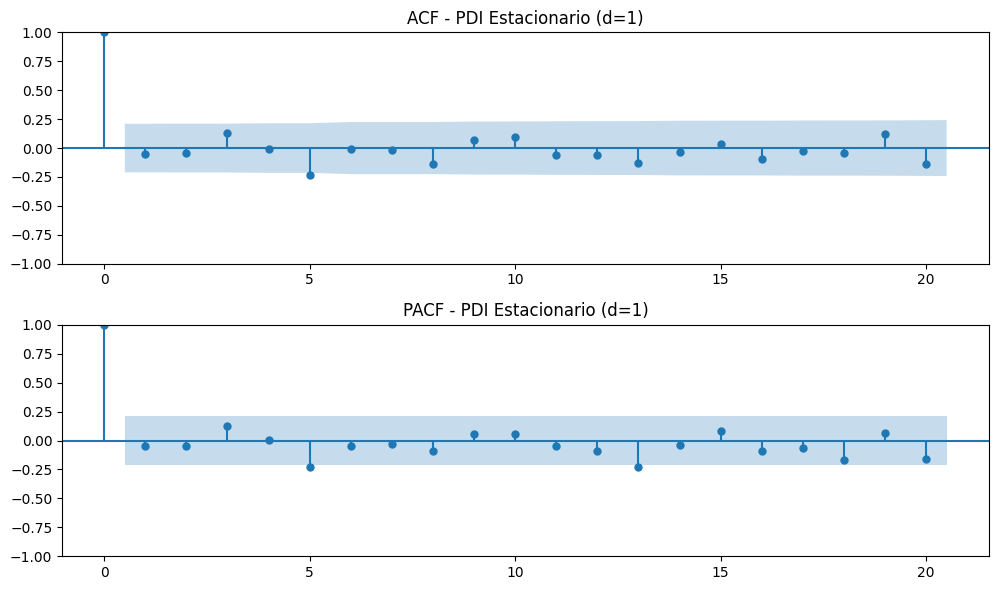


Interpretación ACF/PACF:
• PACF: primer pico significativo → posible valor de p
• ACF:  primer pico significativo → posible valor de q
• Decaimiento lento → combinación ARMA


In [39]:
# =============================================
# 7. IDENTIFICAR p y q CON ACF / PACF
# =============================================
def plot_correlograms(series, title, lags=None):
    if lags is None:
        lags = min(20, len(series)//3)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=lags, ax=ax1, title=f'ACF - {title}')
    plot_pacf(series, lags=lags, ax=ax2, title=f'PACF - {title}')
    plt.tight_layout()
    plt.show()

plot_correlograms(dpi_stationary, f"PDI Estacionario (d={d_opt})")

print("\nInterpretación ACF/PACF:")
print("• PACF: primer pico significativo → posible valor de p")
print("• ACF:  primer pico significativo → posible valor de q")
print("• Decaimiento lento → combinación ARMA")

In [40]:
# =============================================
# 8. ESTIMAR MEJOR MODELO ARIMA (GRID SEARCH)
# =============================================
def find_best_arima(series, p_range=(0,3), d_fixed=None, q_range=(0,3)):
    best_aic = np.inf
    best_order = None
    best_model = None

    d_start = d_fixed if d_fixed is not None else 0
    d_end = d_fixed + 1 if d_fixed is not None else 2

    print("Buscando mejor modelo ARIMA...")
    for p in range(p_range[0], p_range[1]+1):
        for d in range(d_start, d_end):
            for q in range(q_range[0], q_range[1]+1):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue
    print(f"\nMejor modelo: ARIMA{best_order} | AIC: {best_aic:.2f}")
    return best_order, best_model

order, best_model = find_best_arima(dpi, d_fixed=d_opt, p_range=(0,3), q_range=(0,3))

Buscando mejor modelo ARIMA...

Mejor modelo: ARIMA(1, 1, 1) | AIC: 835.76


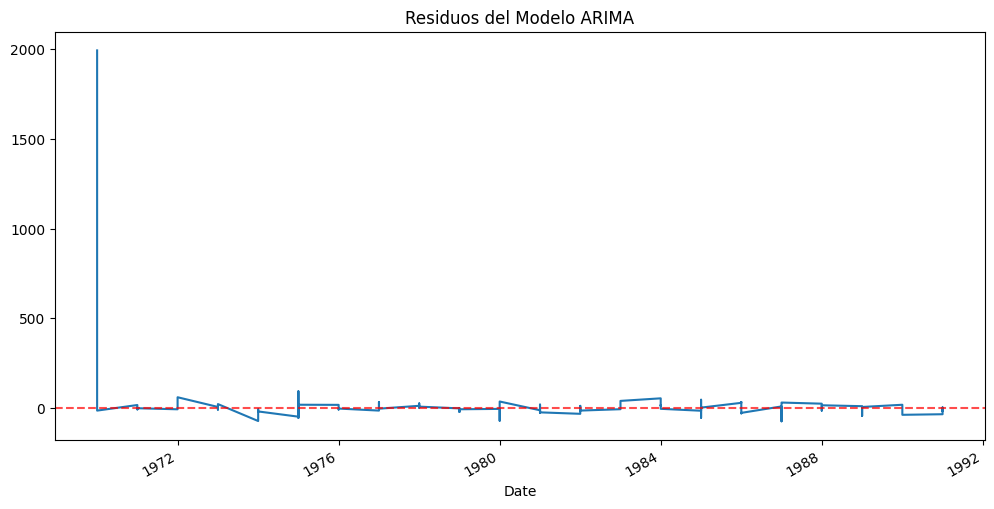

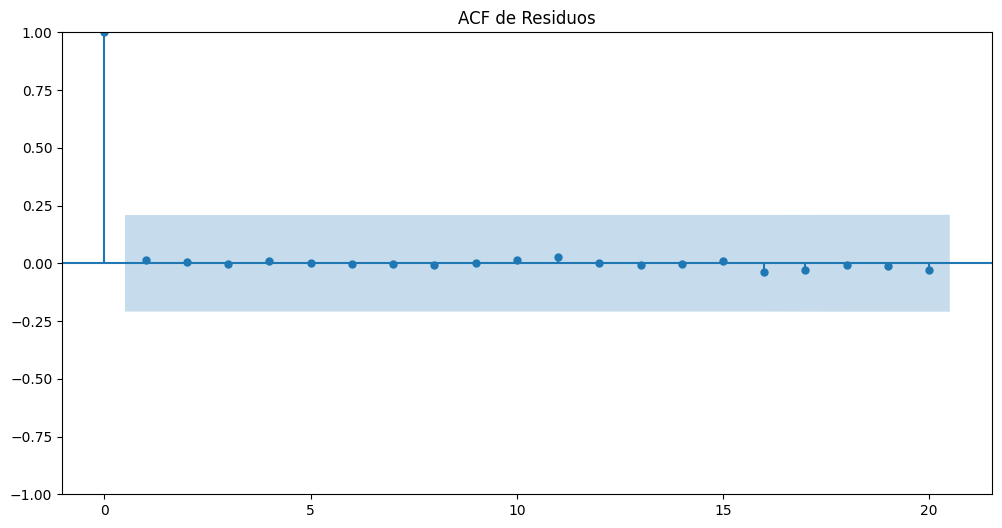


Prueba Ljung-Box (p-valores):
1     OK (>0.05)
2     OK (>0.05)
3     OK (>0.05)
4     OK (>0.05)
5     OK (>0.05)
6     OK (>0.05)
7     OK (>0.05)
8     OK (>0.05)
9     OK (>0.05)
10    OK (>0.05)
11    OK (>0.05)
12    OK (>0.05)
13    OK (>0.05)
14    OK (>0.05)
15    OK (>0.05)
16    OK (>0.05)
17    OK (>0.05)
18    OK (>0.05)
19    OK (>0.05)
20    OK (>0.05)
Name: lb_pvalue, dtype: object

Los residuos son ruido blanco → modelo bien especificado


In [41]:
# =============================================
# 9. DIAGNÓSTICO DE RESIDUOS (RUÍDO BLANCO)
# =============================================
residuals = best_model.resid

# Graficar residuos
plt.figure()
residuals.plot(title='Residuos del Modelo ARIMA')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.show()

# ACF de residuos
plot_acf(residuals, lags=20, title='ACF de Residuos')
plt.show()

# Prueba Ljung-Box
lb_test = acorr_ljungbox(residuals, lags=20, return_df=True)
print("\nPrueba Ljung-Box (p-valores):")
print(lb_test['lb_pvalue'].apply(lambda x: 'OK (>0.05)' if x > 0.05 else 'Rechazado'))

if (lb_test['lb_pvalue'] > 0.05).all():
    print("\nLos residuos son ruido blanco → modelo bien especificado")
else:
    print("\nLos residuos NO son ruido blanco → revisar modelo")

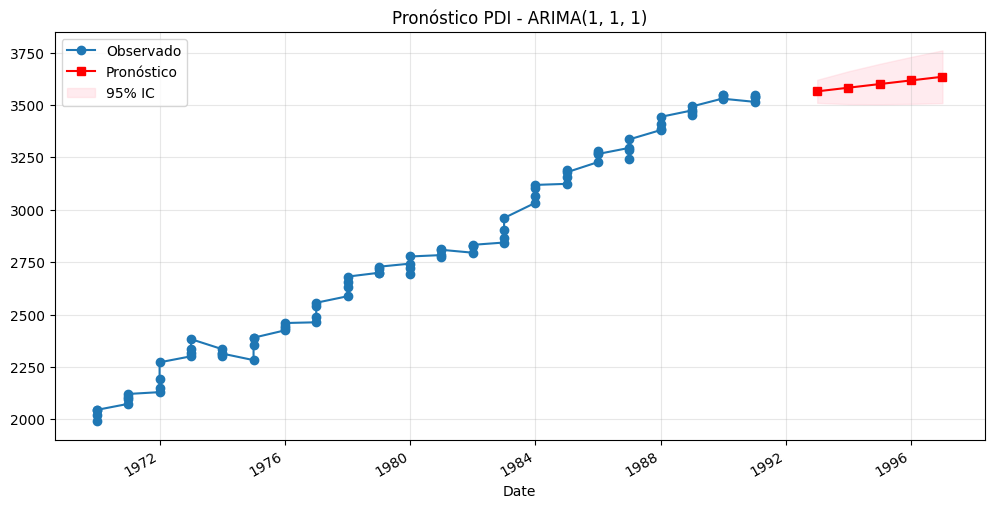


Pronóstico (próximos 5 años):
 Año  Pronóstico PDI  IC Inferior  IC Superior
1992         3564.91      3509.86      3619.95
1993         3582.31      3504.03      3660.59
1994         3599.72      3503.32      3696.11
1995         3617.12      3505.21      3729.03
1996         3634.53      3508.74      3760.31


In [42]:
# =============================================
# 10. PRONÓSTICO Y COMPARACIÓN
# =============================================
forecast_steps = 5
forecast_result = best_model.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Índices futuros
future_years = pd.date_range(start=dpi.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')

# Graficar pronóstico
plt.figure()
dpi.plot(label='Observado', marker='o')
plt.plot(future_years, forecast, label='Pronóstico', color='red', marker='s')
plt.fill_between(future_years, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='95% IC')
plt.title(f'Pronóstico PDI - ARIMA{order}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nPronóstico (próximos {forecast_steps} años):")
forecast_df = pd.DataFrame({
    'Año': future_years.year,
    'Pronóstico PDI': forecast.round(2),
    'IC Inferior': conf_int.iloc[:,0].round(2),
    'IC Superior': conf_int.iloc[:,1].round(2)
})
print(forecast_df.to_string(index=False))

In [45]:
# PARA EXPORTAR

from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Paso 1: Cargar tu archivo .ipynb
print("Por favor, selecciona tu archivo .ipynb")
uploaded = files.upload()

# Paso 2: Obtener el nombre del archivo cargado
notebook_filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {notebook_filename}")

# Paso 3: Leer el notebook
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Paso 4: Convertir a HTML
print("Convirtiendo a HTML...")
html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'
(body, resources) = html_exporter.from_notebook_node(notebook)

# Paso 5: Guardar el archivo HTML
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Conversión completada: {html_filename}")

# Paso 6: Descargar el archivo HTML
print("Descargando archivo HTML...")
files.download(html_filename)
print("¡Listo! Tu archivo HTML ha sido descargado.")

Por favor, selecciona tu archivo .ipynb


Saving ExamenEcoA01452031.ipynb to ExamenEcoA01452031.ipynb

Archivo cargado: ExamenEcoA01452031.ipynb
Convirtiendo a HTML...
Conversión completada: ExamenEcoA01452031.html
Descargando archivo HTML...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Listo! Tu archivo HTML ha sido descargado.


INTERPRETACIÓN:
En mi análisis del PDI concluí que la serie original no es estacionaria: la prueba ADF arrojó p-value = 0.8540 y la KPSS p-value = 0.0100, por lo que rechacé estacionariedad y procedí a diferenciar (d = 1) para estabilizarla. Con la serie estacionarizada, identifiqué y estimé varios ARIMA y el mejor modelo fue ARIMA(1,1,1) con AIC = 835.76. Los residuos del modelo pasaron la prueba de Ljung-Box en múltiples rezagos (p-values > 0.05), por lo que los consideré ruido blanco. Con este modelo, el último PDI observado (1991) fue 3,547.50, y el pronóstico promedio para 1992 hacia 1996 fue 3,599.72, lo que implica un aumento esperado de 52.22 puntos (+1.47%); año por año, los pronósticos puntuales fueron 1992: 3564.91, 1993: 3582.31, 1994: 3599.72, 1995: 3617.12 y 1996: 3634.53 (con intervalos amplios), por lo que interpreto una tendencia de crecimiento moderado con incertidumbre no despreciable; en consecuencia, usaría estos resultados para planeación fiscal y de inversión pública, actualizando el modelo anualmente con datos nuevos.